# Gathering

In [1]:
import pandas as pd
import numpy as np
import requests
import re
import matplotlib.pyplot as plt
import json
import datetime
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
archive_df = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
df_list = []

with open('tweet_json.txt', 'r') as file:
    for line in file:
        tweet = json.loads(line)
        tweet_id = tweet['id']
        retweet_count = tweet['retweet_count']
        fav_count = tweet['favorite_count']
        df_list.append({'tweet_id':tweet_id,
                       'retweet_count': retweet_count,
                       'favorite_count': fav_count})
        
api_df_now = pd.DataFrame(df_list)
api_df_now.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


In [4]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
file_name = url.split('/')[-1]
response = requests.get(url)
if not os.path.isfile(file_name):
    with open (file_name,'wb') as f:
        f.write(response.content)
image_predictions_df = pd.read_csv(file_name, sep = '\t' )


# Assessing

In [5]:
archive_df

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [6]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [7]:
sum(archive_df['tweet_id'].duplicated())

0

In [8]:
archive_df['name'].value_counts()

None        745
a            55
Charlie      12
Lucy         11
Oliver       11
           ... 
Dex           1
Hector        1
Griswold      1
Finnegus      1
Pubert        1
Name: name, Length: 957, dtype: int64

In [9]:
archive_df['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [10]:
archive_df['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [11]:
image_predictions_df

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [12]:
image_predictions_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [13]:
image_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [14]:
sum(image_predictions_df['jpg_url'].duplicated())

66

In [15]:
api_df_now

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
...,...,...,...
2349,666049248165822465,41,111
2350,666044226329800704,147,311
2351,666033412701032449,47,128
2352,666029285002620928,48,132


In [16]:
api_df_now.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


# Cleaning

In [17]:
archive_df_clean = archive_df.copy()
image_predictions_df_clean = image_predictions_df.copy()
api_df_now_clean = api_df_now.copy()

In [18]:
#code
archive_df_clean['timestamp'] = pd.to_datetime(archive_df_clean['timestamp'])

In [19]:
#Test
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   int64              
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2356 non-null   datetime64[ns, UTC]
 4   source                      2356 non-null   object             
 5   text                        2356 non-null   object             
 6   retweeted_status_id         181 non-null    float64            
 7   retweeted_status_user_id    181 non-null    float64            
 8   retweeted_status_timestamp  181 non-null    object             
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2356 non-null   int64           

In [20]:
#code
archive_df_clean['source'] = archive_df_clean['source'].str.replace('<a href="http://twitter.com/download/iphone" rel="nofollow">','')
archive_df_clean['source'] = archive_df_clean['source'].str.replace('<a href="http://twitter.com" rel="nofollow">','')
archive_df_clean['source'] = archive_df_clean['source'].str.replace('<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">','')
archive_df_clean['source'] = archive_df_clean['source'].str.replace('</a>','')

In [21]:
#test
archive_df_clean['source'].head()

0    Twitter for iPhone
1    Twitter for iPhone
2    Twitter for iPhone
3    Twitter for iPhone
4    Twitter for iPhone
Name: source, dtype: object

In [22]:
#code
archive_df_clean['rating_denominator'] = 10

In [23]:
#Test
archive_df_clean['rating_denominator'].value_counts()

10    2356
Name: rating_denominator, dtype: int64

In [24]:
#code
archive_df_clean['tweet_id'] = archive_df_clean['tweet_id'].astype(str)
image_predictions_df_clean['tweet_id'] = image_predictions_df_clean['tweet_id'].astype(str)
api_df_now_clean['tweet_id'] = api_df_now_clean['tweet_id'].astype(str)

In [25]:
#test
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   object             
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2356 non-null   datetime64[ns, UTC]
 4   source                      2356 non-null   object             
 5   text                        2356 non-null   object             
 6   retweeted_status_id         181 non-null    float64            
 7   retweeted_status_user_id    181 non-null    float64            
 8   retweeted_status_timestamp  181 non-null    object             
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2356 non-null   int64           

In [26]:
image_predictions_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   object 
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


In [27]:
api_df_now_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2354 non-null   object
 1   retweet_count   2354 non-null   int64 
 2   favorite_count  2354 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 55.3+ KB


In [28]:
#code
archive_df_clean['doggo'] = archive_df_clean['doggo'].replace('None','')
archive_df_clean['floofer'] = archive_df_clean['floofer'].replace('None','')
archive_df_clean['pupper'] = archive_df_clean['pupper'].replace('None','')
archive_df_clean['puppo'] = archive_df_clean['puppo'].replace('None','')

In [29]:
#test
archive_df_clean['doggo'].value_counts()

         2259
doggo      97
Name: doggo, dtype: int64

In [30]:
archive_df_clean['floofer'].value_counts()

           2346
floofer      10
Name: floofer, dtype: int64

In [31]:
archive_df_clean['pupper'].value_counts()

          2099
pupper     257
Name: pupper, dtype: int64

In [32]:
archive_df_clean['puppo'].value_counts()

         2326
puppo      30
Name: puppo, dtype: int64

In [33]:
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   object             
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2356 non-null   datetime64[ns, UTC]
 4   source                      2356 non-null   object             
 5   text                        2356 non-null   object             
 6   retweeted_status_id         181 non-null    float64            
 7   retweeted_status_user_id    181 non-null    float64            
 8   retweeted_status_timestamp  181 non-null    object             
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2356 non-null   int64           

In [34]:
#code
tweets_with_image = list(image_predictions_df_clean.tweet_id.unique())
len(tweets_with_image) == archive_df_clean.tweet_id.isin(tweets_with_image).sum()

True

In [35]:
archive_df_clean = archive_df_clean[archive_df_clean.tweet_id.isin(tweets_with_image)]

In [36]:
#test
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2075 non-null   object             
 1   in_reply_to_status_id       23 non-null     float64            
 2   in_reply_to_user_id         23 non-null     float64            
 3   timestamp                   2075 non-null   datetime64[ns, UTC]
 4   source                      2075 non-null   object             
 5   text                        2075 non-null   object             
 6   retweeted_status_id         81 non-null     float64            
 7   retweeted_status_user_id    81 non-null     float64            
 8   retweeted_status_timestamp  81 non-null     object             
 9   expanded_urls               2075 non-null   object             
 10  rating_numerator            2075 non-null   int64           

In [37]:
#code
retweet_entries = archive_df_clean.retweeted_status_id.notnull()
archive_df_clean[retweet_entries].shape[0]
reply_entries = archive_df_clean.in_reply_to_status_id.notnull()
archive_df_clean[reply_entries].shape[0]
archive_df_clean = archive_df_clean[~retweet_entries]
archive_df_clean = archive_df_clean[~reply_entries]
#droping unnecessary columns
archive_df_clean.drop(columns=['in_reply_to_status_id', 
                    'in_reply_to_user_id', 
                    'retweeted_status_id', 
                    'retweeted_status_user_id', 
                    'retweeted_status_timestamp'], inplace=True)

In [38]:
#test
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1971 non-null   object             
 1   timestamp           1971 non-null   datetime64[ns, UTC]
 2   source              1971 non-null   object             
 3   text                1971 non-null   object             
 4   expanded_urls       1971 non-null   object             
 5   rating_numerator    1971 non-null   int64              
 6   rating_denominator  1971 non-null   int64              
 7   name                1971 non-null   object             
 8   doggo               1971 non-null   object             
 9   floofer             1971 non-null   object             
 10  pupper              1971 non-null   object             
 11  puppo               1971 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(2

In [39]:
#code
np.logical_not(image_predictions_df_clean.tweet_id.isin(list(archive_df_clean.tweet_id)))
image_predictions_df_clean = image_predictions_df_clean[~np.logical_not(image_predictions_df_clean.tweet_id.isin(list(archive_df_clean.tweet_id)))]

In [40]:
#test
image_predictions_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  1971 non-null   object 
 1   jpg_url   1971 non-null   object 
 2   img_num   1971 non-null   int64  
 3   p1        1971 non-null   object 
 4   p1_conf   1971 non-null   float64
 5   p1_dog    1971 non-null   bool   
 6   p2        1971 non-null   object 
 7   p2_conf   1971 non-null   float64
 8   p2_dog    1971 non-null   bool   
 9   p3        1971 non-null   object 
 10  p3_conf   1971 non-null   float64
 11  p3_dog    1971 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 159.8+ KB


In [41]:
archive_df_clean['rating_numerator'] = archive_df_clean['text'].str.extract('(\d*\.\d+|\d+)', expand=False).astype(float)


In [42]:
archive_df_clean['rating_numerator'].value_counts()

12.00      435
10.00      397
11.00      371
13.00      249
9.00       138
8.00        95
7.00        48
6.00        34
5.00        31
14.00       30
3.00        26
2.00        22
4.00        22
0.10         9
1.00         8
0.00         5
0.11         4
0.90         3
80.00        2
2015.00      2
50.00        2
100.00       2
31.00        2
46.00        1
9.75         1
98.00        1
47.00        1
17.00        1
84.00        1
13.50        1
24.00        1
0.80         1
204.00       1
8.98         1
92.49        1
420.00       1
121.00       1
97.00        1
1776.00      1
150.00       1
2002.00      1
2003.00      1
0.30         1
0.12         1
11.27        1
400.00       1
165.00       1
1949.00      1
11.26        1
2016.00      1
88.00        1
144.00       1
61.00        1
33.00        1
44.00        1
60.00        1
45.00        1
Name: rating_numerator, dtype: int64

In [43]:
#code
image_predictions_df_clean.rename(columns = {'p1':'prediction_1',
                                           'p1_conf':'prediction_reality_1',
                                           'p1_dog':'boolean_prediction_dogtype_1',
                                           'p2':'prediction_2',
                                           'p2_conf':'prediction_reality_2',
                                           'p2_dog':'boolean_prediction_dogtype_2',
                                            'p3':'prediction_3',
                                           'p3_conf':'prediction_reality_3',
                                           'p3_dog':'boolean_prediction_dogtype_3'}, inplace = True)

In [44]:
#test
image_predictions_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      1971 non-null   object 
 1   jpg_url                       1971 non-null   object 
 2   img_num                       1971 non-null   int64  
 3   prediction_1                  1971 non-null   object 
 4   prediction_reality_1          1971 non-null   float64
 5   boolean_prediction_dogtype_1  1971 non-null   bool   
 6   prediction_2                  1971 non-null   object 
 7   prediction_reality_2          1971 non-null   float64
 8   boolean_prediction_dogtype_2  1971 non-null   bool   
 9   prediction_3                  1971 non-null   object 
 10  prediction_reality_3          1971 non-null   float64
 11  boolean_prediction_dogtype_3  1971 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 159.

In [45]:
#code
archive_df_clean['dog_stage'] = archive_df_clean['doggo']+archive_df_clean['floofer']+archive_df_clean['pupper']+archive_df_clean['puppo']

In [46]:
archive_df_clean['dog_stage'].value_counts()

                1668
pupper           201
doggo             63
puppo             22
doggopupper        8
floofer            7
doggofloofer       1
doggopuppo         1
Name: dog_stage, dtype: int64

In [47]:
archive_df_clean['dog_stage'].replace('',np.NaN, inplace= True)
archive_df_clean['dog_stage'].replace('doggopupper','doggo-pupper',inplace=True)
archive_df_clean['dog_stage'].replace('doggopuppo','doggo-puppo',inplace=True)
archive_df_clean['dog_stage'].replace('doggofloofer','doggo-floofer',inplace=True)
archive_df_clean.drop(columns=['doggo','floofer','puppo','pupper'],inplace= True)

In [48]:
#test
archive_df_clean['dog_stage'].value_counts()


pupper           201
doggo             63
puppo             22
doggo-pupper       8
floofer            7
doggo-floofer      1
doggo-puppo        1
Name: dog_stage, dtype: int64

In [49]:
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2355
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1971 non-null   object             
 1   timestamp           1971 non-null   datetime64[ns, UTC]
 2   source              1971 non-null   object             
 3   text                1971 non-null   object             
 4   expanded_urls       1971 non-null   object             
 5   rating_numerator    1971 non-null   float64            
 6   rating_denominator  1971 non-null   int64              
 7   name                1971 non-null   object             
 8   dog_stage           303 non-null    object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(1), object(6)
memory usage: 154.0+ KB


In [50]:
#code
data_clean = archive_df_clean
data_clean = pd.merge(data_clean, image_predictions_df_clean, on = 'tweet_id', how='left')
data_clean = pd.merge(data_clean, api_df_now_clean, on = 'tweet_id', how='left')

In [51]:
#test
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype              
---  ------                        --------------  -----              
 0   tweet_id                      1971 non-null   object             
 1   timestamp                     1971 non-null   datetime64[ns, UTC]
 2   source                        1971 non-null   object             
 3   text                          1971 non-null   object             
 4   expanded_urls                 1971 non-null   object             
 5   rating_numerator              1971 non-null   float64            
 6   rating_denominator            1971 non-null   int64              
 7   name                          1971 non-null   object             
 8   dog_stage                     303 non-null    object             
 9   jpg_url                       1971 non-null   object             
 10  img_num                       1971 n

# Storage

In [52]:
data_clean.to_csv('twitter_archive_master.csv',index=False)

# Visualization

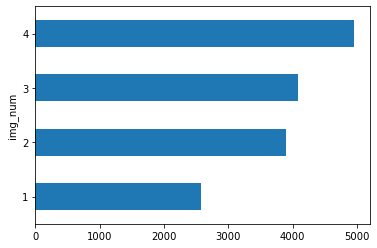

In [53]:
data_clean.groupby(['img_num']).retweet_count.mean().plot(kind='barh')

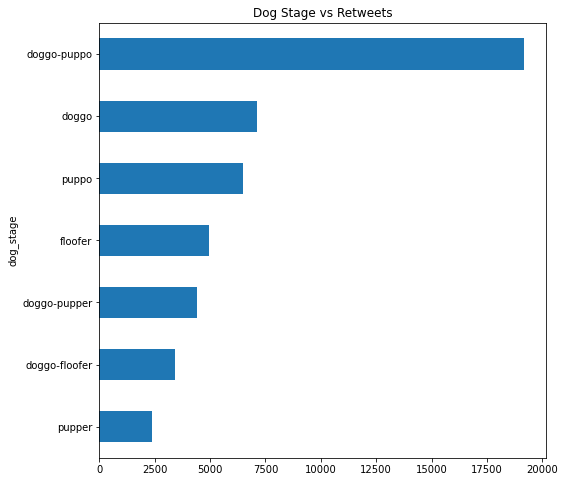

In [54]:

data_clean.groupby(['dog_stage']).retweet_count.mean().sort_values(ascending=False)[12::-1].plot(kind='barh', title= 'Dog Stage vs Retweets', figsize=(8,8))

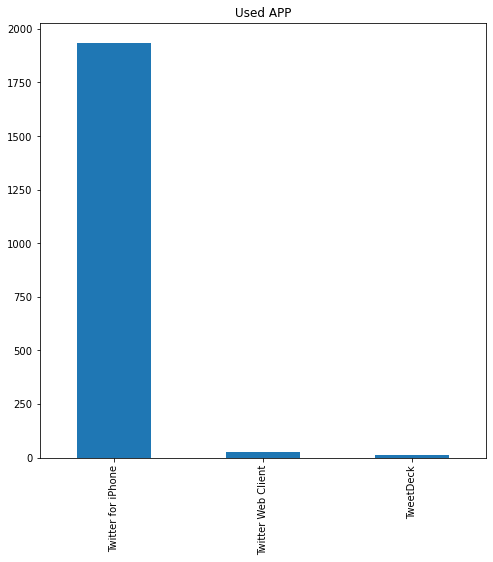

In [55]:
data_clean.source.value_counts().plot(kind='bar', title='Used APP',figsize=(8,8))

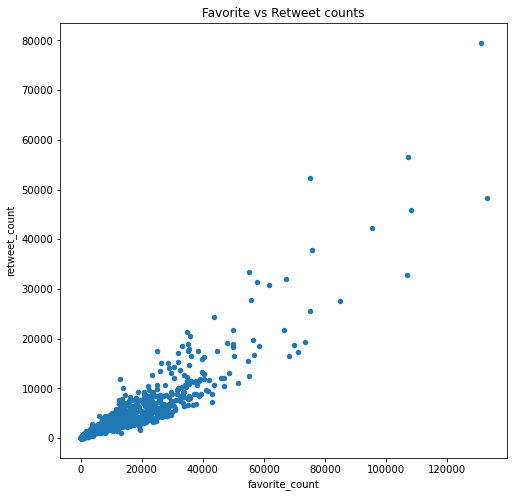

In [56]:
data_clean.plot(x='favorite_count',y='retweet_count',kind='scatter',title='Favorite vs Retweet counts', figsize=(8,8))